In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os

In [12]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
class HandWriteStyle(Dataset):
    def __init__(self,image_folder):
        self.image_path=[image_folder+'/'+x for x in os.listdir(image_folder)]
        self.len=len(image_folder)
    def __len__(self):
        return self.len
    def __getitem__(self, item):
        image=cv2.imread(self.image_path[item]).astype(np.float32)/255.0
        return torch.tensor(image)
    def plot_image(self,index):
        print('This is the picture',index)
        image=cv2.imread(self.image_path[index])
        plt.imshow(image)

In [6]:
styleDataset=HandWriteStyle('./letter-style')

In [31]:
def plt_progress(data):
    df=pd.DataFrame(data,columns=['loss'])
    df.plot(ylim=(0),figsize=(16,8),alpha=0.5,marker='.',grid=True,yticks=[0,0.25,0.5,1.0,5.0])

In [26]:
class View(nn.Module):
    def __init__(self,shape):
        super(View, self).__init__()
        self.shape=shape
    def forward(self,x):
        x=x.view(self.shape)
        return x
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model=nn.Sequential(
            View(256*256*3),
            nn.Linear(256*256*3,100),
            nn.LeakyReLU(),
            nn.LayerNorm(100),
            nn.Linear(100,1),
            nn.Sigmoid()
        )
    def forward(self,x):
        return self.model(x)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model=nn.Sequential(
            nn.Linear(100,3*10*10),
            nn.LeakyReLU(),
            nn.LayerNorm(3*10*10),
            nn.Linear(3*10*10,3*256*256),
            nn.Sigmoid(),
            View((256,256,3))
        )
    def forward(self,x):
        z=torch.randn(100).to(device)
        return self.model(z)

In [27]:
def train_one_step(D,G,image,loss_fun,optim_D,optim_G):
    real_label=torch.ones([1]).to(device)
    fake_label=torch.zeros([1]).to(device)
    # 1
    loss_d=loss_fun(D(image),real_label)
    loss_d.backward()
    optim_D.step()
    optim_D.zero_grad()
    loss1=loss_d.item()
    # 2
    loss_d=loss_fun(D(G(image).detach()),fake_label)
    loss_d.backward()
    optim_D.step()
    optim_D.zero_grad()
    loss2=loss_d.item()
    # 3
    loss_g=loss_fun(D(G(image)),real_label)
    loss_g.backward()
    optim_G.step()
    optim_G.zero_grad()
    loss3=loss_g.item()
    return loss1,loss2,loss3

In [28]:
%%time
D=Discriminator()
D.to(device)
G=Generator()
G.to(device)
epochs=4
loss_d=[]
loss_g=[]
loss_fun=nn.BCELoss()
optim_D=torch.optim.Adam(params=D.parameters(),lr=0.0001)
optim_G=torch.optim.Adam(params=G.parameters(),lr=0.0001)
for epoch in range(epochs):
    print('epoch:{}/{}'.format(epoch+1,epochs))
    for i,image in enumerate(styleDataset):
        loss1,loss2,loss3=train_one_step(D,G,image.to(device),loss_fun,optim_D,optim_G)
        loss_d.extend([loss1,loss2])
        loss_g.append(loss3)
        if i%100==0:
            print('epoch:{}, step:{},loss1:{}, loss2:{}, loss3:{}'.format(
                epoch,i,loss1,loss2,loss3
            ))

epoch:1/4
epoch:0, step:0,loss1:0.2225647270679474, loss2:5.280747413635254, loss3:0.012570803053677082
epoch:0, step:100,loss1:0.386711984872818, loss2:1.1109412908554077, loss3:0.40524041652679443
epoch:0, step:200,loss1:0.3991193175315857, loss2:1.1040215492248535, loss3:0.3969306945800781
epoch:0, step:300,loss1:0.40590569376945496, loss2:1.1350946426391602, loss3:0.397485613822937
epoch:0, step:400,loss1:0.39049553871154785, loss2:1.119815468788147, loss3:0.4113435745239258
epoch:0, step:500,loss1:0.4289063513278961, loss2:1.143958330154419, loss3:0.40835216641426086
epoch:0, step:600,loss1:0.4115617871284485, loss2:1.1267651319503784, loss3:0.40620172023773193
epoch:0, step:700,loss1:0.40510091185569763, loss2:1.1062713861465454, loss3:0.3988710343837738
epoch:0, step:800,loss1:0.4011334180831909, loss2:1.0657925605773926, loss3:0.40745189785957336
epoch:0, step:900,loss1:0.39700746536254883, loss2:1.092319369316101, loss3:0.41529381275177
epoch:0, step:1000,loss1:0.4030152857303

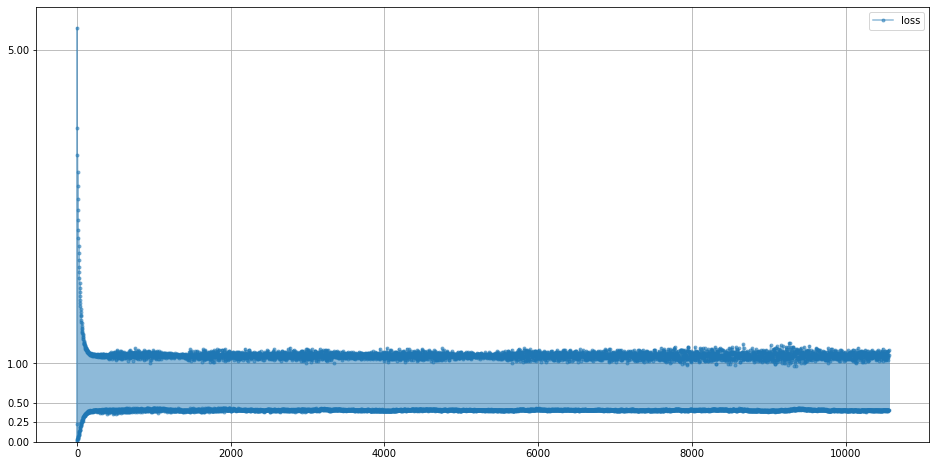

In [32]:
plt_progress(loss_d)

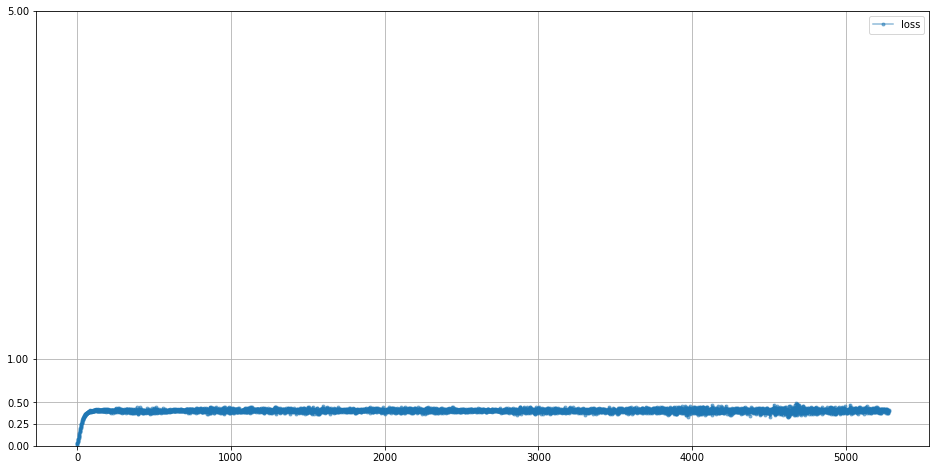

In [33]:
plt_progress(loss_g)

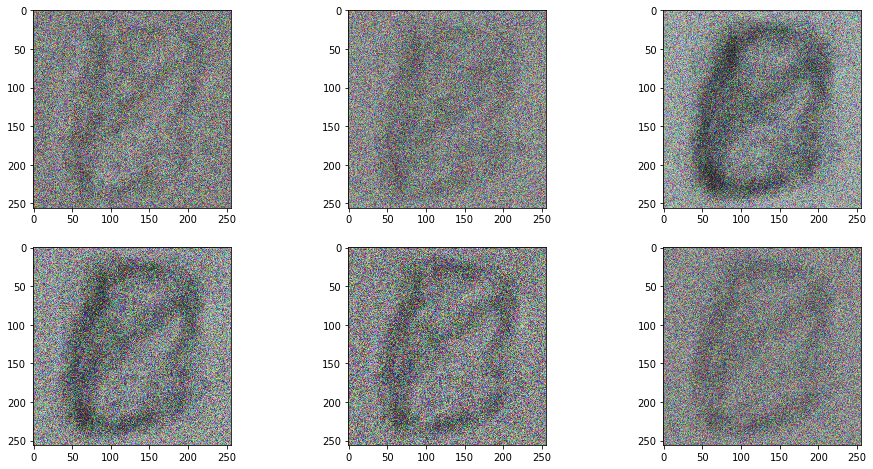

In [37]:
f,ax=plt.subplots(2,3,figsize=(16,8))
for i in range(2):
    for j in range(3):
        output=G.forward(1)
        img=output.detach().cpu().numpy()
        ax[i,j].imshow(img,interpolation='none',cmap='Blues')